In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [60]:
dataset = pd.read_csv('../secondMMRintData/tryOrbEl.csv')

In [61]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [62]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 9.09 s, sys: 100 ms, total: 9.19 s
Wall time: 10.1 s


In [63]:
dataset

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPnear,EMfar,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,0,0.221502,0.098431,9.878834e-03,0.013642,0.007103,0.300893,0.093415,0.001595,0.003112,...,0.023629,0.061076,0.053981,0.007530,0.004649,True,False,1.235665e+07,8.315223e+07,0
1,1,0.190647,0.009185,1.703367e-03,0.019474,0.015939,0.403777,0.249341,0.003783,0.008003,...,0.013028,0.085497,0.017682,0.082772,0.071393,True,False,1.348749e+05,2.133072e+05,0
2,2,0.125660,0.426660,1.310313e-01,0.033117,0.022168,0.720557,0.000531,0.000266,0.000287,...,0.011262,0.040973,0.042240,0.054516,0.051803,True,False,1.276428e+04,9.321863e+03,0
3,3,0.216684,0.002876,1.857040e-07,0.004557,0.001577,0.235460,0.027521,0.013379,0.001208,...,0.000034,0.057376,0.013245,0.057501,0.040897,True,True,1.000000e+09,1.000000e+09,0
4,4,0.024455,0.423830,1.145611e-01,0.002436,0.000582,0.034058,0.079484,0.053510,0.003246,...,0.007250,0.018995,0.006777,0.011759,0.007401,True,False,8.791890e+01,8.791890e+01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.447117,2.475049e-02,0.016075,0.016330,0.664222,0.001175,0.000000,0.004940,...,0.038914,0.154595,0.098020,0.132139,0.073446,True,False,6.990387e+05,8.267916e+05,0
138539,138539,0.251338,0.749336,1.701463e-03,0.003767,0.002099,0.272822,0.017013,0.004713,0.007723,...,0.029073,0.030636,0.017757,0.043224,0.003523,True,False,3.075749e+08,6.576003e+08,0
138540,138540,0.131799,0.324267,2.940005e-02,0.017772,0.017278,0.366664,0.059764,0.006983,0.001049,...,0.051811,0.083804,0.064086,0.047189,0.045870,True,False,1.193822e+07,3.363291e+07,0
138541,138541,0.209454,1.205802,5.207774e-02,0.033014,0.057969,0.395073,0.029166,0.002591,0.020718,...,0.068171,0.055297,0.091233,0.217038,0.183490,True,False,2.064407e+08,4.316851e+07,0


In [64]:
dataset['EMavg'] = (dataset['EMcrossfar']+dataset['EMcrossnear']+dataset['EMcrossouter'])/3

In [65]:
dataset['Widavg']= (dataset['MMRstrengthWnear']+dataset['MMRstrengthWfar']+dataset['MMRstrengthWouter'])/3

In [66]:
dataset = dataset.iloc[25000:,:]


In [67]:


twoBRwidth = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter','twoMMRstrengthWnear','twoMMRstrengthWfar','twoMMRstrengthWouter']
twoBRinW = ['MMRinWidnear','MMRinWidfar','MMRinWidouter','twoMMRinWidnear','twoMMRinWidfar','twoMMRinWidouter']

OGfeatures = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','MEGNO', 'MEGNOstd']

MMRDATA = ['threeBRfillfac','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter', 'EMcrossnear','EMcrossfar','EMcrossouter','eccMag','eccDir','pomegastd',
           ]+twoBRwidth

TestFirst = ['threeBRfillfac', 'threeBRfillstd','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter']

testfew = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter', 'threeBRfillfac','EMcrossnear','EMcrossfar','EMcrossouter']

testavg = ['EMavg','Widavg','threeBRfillfac']

orbital = []
e = []
a = []
P = []
pomega = []
Omega = []
w = []
m = []
for x in ['1','2','3']:
    e.append('e'+x)
    a.append('a'+x)
    P.append('P'+x)
    pomega.append('pomega'+x)
    Omega.append('Omega'+x)
    w.append('w'+x)
    m.append('m'+x)
orbital = e + a + P + pomega + Omega + w + m

In [68]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [69]:
filtData[orbital]

,e1,e2,e3,a1,a2,a3,P1,P2,P3,pomega1,...,pomega3,Omega1,Omega2,Omega3,w1,w2,w3,m1,m2,m3
25000,0.000176,0.041986,0.034243,1.0,1.504063,1.594658,1.0,1.844574,2.013717,-1.446076,...,0.641958,-2.306424,-2.950806,-0.984932,0.860348,2.779260,1.626890,3.984920e-06,1.244417e-05,2.531702e-07
25001,0.000931,0.008409,0.089538,1.0,1.240504,1.340424,1.0,1.381636,1.551884,1.663546,...,-0.980935,-0.102858,-2.705702,-0.960189,1.766404,2.589262,6.262439,2.065557e-07,1.681432e-05,6.830431e-07
25002,0.088506,0.045729,0.011546,1.0,1.129660,2.261558,1.0,1.200645,3.400821,1.088873,...,-2.792396,0.172441,2.000975,-0.679907,0.916432,5.276309,4.170697,1.797281e-07,3.209939e-05,9.648477e-05
25003,0.105082,0.061286,0.000208,1.0,1.406112,2.007603,1.0,1.667357,2.844537,1.468864,...,-1.754179,-0.880187,-0.894421,-2.995106,2.349051,2.707713,1.240927,4.704418e-05,6.920889e-06,1.615758e-05
25004,0.035674,0.058308,0.000058,1.0,1.059897,1.332922,1.0,1.091177,1.538851,-4.194269,...,-2.218460,-2.730043,3.015926,0.715007,4.818959,5.343256,3.349719,3.514145e-06,7.277734e-07,4.655600e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,0.098697,0.055973,0.038755,1.0,1.664222,1.801058,1.0,2.146925,2.417061,-1.392740,...,2.370762,-1.986416,-1.304489,0.789342,0.593676,3.118004,1.581420,7.421231e-05,3.262045e-07,1.797223e-05
138539,0.042992,0.029663,0.000991,1.0,1.251338,1.592730,1.0,1.399777,2.010059,0.345426,...,2.140864,0.105004,-2.622912,2.787067,0.240422,1.816402,5.636983,7.304962e-07,1.252616e-05,7.962694e-06
138540,0.047731,0.084424,0.000777,1.0,1.131799,1.546790,1.0,1.204069,1.923727,2.936098,...,-2.554465,0.721274,-0.121158,-1.067540,2.214824,3.206445,4.796260,9.256666e-05,1.185978e-05,3.800687e-06
138541,0.185046,0.091380,0.042639,1.0,1.209454,1.687277,1.0,1.330065,2.191636,2.906814,...,0.560677,2.339363,0.325401,-0.535495,0.567451,0.656802,1.096172,1.973852e-05,5.127421e-05,1.439586e-07


In [70]:
scrambled = filtData.sample(frac=1)

In [71]:
scrambled = scrambled.reset_index()

In [72]:
scrambled

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
0,47876,47876,0.117807,163.862556,0.051458,0.007308,0.007659,0.268475,0.333735,0.003027,...,0.031644,0.102048,0.094936,True,False,1.093794e+06,1.760805e+06,0,0.268065,0.006345
1,49920,49920,0.076171,0.112403,0.092916,0.000889,0.003582,0.446331,0.000964,0.000896,...,0.016997,0.026206,0.017020,True,False,3.216250e+06,2.578397e+04,0,0.359667,0.001909
2,137066,137066,0.127298,0.152389,0.013040,0.007932,0.007712,0.404270,0.228774,0.002258,...,0.040813,0.043097,0.042407,True,False,1.183902e+04,1.999050e+04,0,0.371533,0.008342
3,116066,116066,0.047163,0.305322,0.008832,0.001074,0.001079,0.105550,0.036735,0.006812,...,0.000755,0.005011,0.000776,True,False,2.714494e+04,2.393479e+04,0,0.103468,0.002128
4,102125,102125,0.409212,0.461120,0.019917,0.026951,0.024165,0.416491,0.009647,0.000400,...,0.009867,0.229019,0.123792,True,True,1.000000e+09,1.000000e+09,0,0.607279,0.020225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113538,38730,38730,0.407097,0.373667,0.005073,0.011283,0.009497,0.570932,0.315055,0.000000,...,0.069436,0.064345,0.058588,True,False,1.131147e+04,6.306833e+04,0,0.729494,0.018007
113539,74899,74899,0.216397,0.081809,0.000672,0.010996,0.004179,0.305102,0.160724,0.001199,...,0.009612,0.073973,0.018561,True,True,1.000000e+09,1.000000e+09,0,0.369674,0.008035
113540,132490,132490,0.040191,0.063225,0.038454,0.002255,0.003268,0.377737,0.001308,0.000382,...,0.010231,0.023140,0.011439,True,False,1.723406e+05,1.111280e+05,0,0.283680,0.001346
113541,118849,118849,0.107182,0.911305,0.088217,0.024264,0.032879,0.503586,0.003794,0.003168,...,0.000241,0.048066,0.024820,True,False,2.482331e+06,4.125291e+06,0,0.425170,0.010187


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [73]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]


# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [74]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [75]:
realTest = test.loc[test['prelimStable']==True]

In [76]:
testT = realTest.loc[test['Stable'] == True]
testF = realTest.loc[test['Stable'] == False]


In [77]:
tT = pd.concat([testT, testF.sample(n=7300)])
tT = tT.sample(frac=1)

In [78]:
from sklearn.metrics import accuracy_score

In [79]:
filtData

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
25000,25000,0.060234,0.321712,0.033606,0.007654,0.007718,0.504063,0.000474,0.000232,0.001144,...,0.031815,0.034331,0.001969,True,False,1.545872e+06,3.063700e+06,0,0.386318,0.004034
25001,25001,0.080547,0.337946,0.101132,0.013123,0.018941,0.240504,0.007460,0.002233,0.013025,...,0.008305,0.090358,0.068559,True,True,9.990000e+08,9.990000e+08,0,0.220492,0.009404
25002,25002,0.129660,1.220971,0.019313,0.016442,0.015986,1.001981,0.010601,0.000046,0.014967,...,0.006878,0.097347,0.011404,True,True,9.990000e+08,9.990000e+08,0,0.797733,0.010560
25003,25003,0.406112,0.753716,0.001684,0.005132,0.002302,0.427768,0.009978,0.002538,0.006365,...,0.018246,0.105290,0.078165,True,False,2.287671e+06,8.392234e+06,0,0.613828,0.008413
25004,25004,0.059897,0.469035,0.015661,0.004638,0.004676,0.257596,0.042775,0.008156,0.003795,...,0.000876,0.035697,0.002483,True,False,9.668931e+05,3.380350e+05,0,0.216805,0.007142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.447117,0.024750,0.016075,0.016330,0.664222,0.001175,0.000000,0.004940,...,0.098020,0.132139,0.073446,True,False,6.990387e+05,8.267916e+05,0,0.515834,0.007714
138539,138539,0.251338,0.749336,0.001701,0.003767,0.002099,0.272822,0.017013,0.004713,0.007723,...,0.017757,0.043224,0.003523,True,False,3.075749e+08,6.576003e+08,0,0.372297,0.005352
138540,138540,0.131799,0.324267,0.029400,0.017772,0.017278,0.366664,0.059764,0.006983,0.001049,...,0.064086,0.047189,0.045870,True,False,1.193822e+07,3.363291e+07,0,0.348418,0.014406
138541,138541,0.209454,1.205802,0.052078,0.033014,0.057969,0.395073,0.029166,0.002591,0.020718,...,0.091233,0.217038,0.183490,True,False,2.064407e+08,4.316851e+07,0,0.430601,0.028591


In [80]:
dataset['index'].duplicated().value_counts()

index
False    113543
Name: count, dtype: int64

In [49]:
testModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [50]:
testModel.fit(train[a + e + m], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [53]:
resPred = testModel.predict_proba(tT[a + e + m])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(testModel.predict(tT[a + e + m]), tT["Stable"]))

0.9197686570813142
0.828963004040244


In [52]:
plot.value_counts('Stable')

NameError: name 'plot' is not defined

In [ ]:
feat_imp = pd.Series(testModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

NotFittedError: need to call fit or load_model beforehand

In [ ]:
which = (filtData['MMRstrengthnear']+filtData['MMRstrengthfar']+filtData['MMRstrengthouter'])

In [ ]:
filtData['avarage']=which

In [ ]:
filtData['Wavarage']=(filtData['MMRstrengthWnear']+filtData['MMRstrengthWfar']+filtData['MMRstrengthWouter'])/3

In [ ]:
np.median(filtData['avarage'])

0.42239726010197315

In [ ]:
#filtData = filtData.drop(['avarage'], axis=1)

In [ ]:
filtData

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,avarage,Wavarage
0,0,0.221502,0.098431,9.878834e-03,0.013642,0.007103,0.300893,0.093415,0.001595,0.003112,...,0.004649,True,False,1.235665e+07,8.315223e+07,0,0.370479,0.009765,0.632254,0.009765
1,1,0.190647,0.009185,1.703367e-03,0.019474,0.015939,0.403777,0.249341,0.003783,0.008003,...,0.071393,True,False,1.348749e+05,2.133072e+05,0,0.421943,0.009333,0.258671,0.009333
2,2,0.125660,0.426660,1.310313e-01,0.033117,0.022168,0.720557,0.000531,0.000266,0.000287,...,0.051803,True,False,1.276428e+04,9.321863e+03,0,0.594326,0.013826,0.428024,0.013826
3,3,0.216684,0.002876,1.857040e-07,0.004557,0.001577,0.235460,0.027521,0.013379,0.001208,...,0.040897,True,True,1.000000e+09,1.000000e+09,0,0.318436,0.002047,0.030655,0.002047
4,4,0.024455,0.423830,1.145611e-01,0.002436,0.000582,0.034058,0.079484,0.053510,0.003246,...,0.007401,True,False,8.791890e+01,8.791890e+01,0,0.039287,0.002854,0.611820,0.002854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.447117,2.475049e-02,0.016075,0.016330,0.664222,0.001175,0.000000,0.004940,...,0.073446,True,False,6.990387e+05,8.267916e+05,0,0.515834,0.007714,0.457666,0.007714
138539,138539,0.251338,0.749336,1.701463e-03,0.003767,0.002099,0.272822,0.017013,0.004713,0.007723,...,0.003523,True,False,3.075749e+08,6.576003e+08,0,0.372297,0.005352,0.925451,0.005352
138540,138540,0.131799,0.324267,2.940005e-02,0.017772,0.017278,0.366664,0.059764,0.006983,0.001049,...,0.045870,True,False,1.193822e+07,3.363291e+07,0,0.348418,0.014406,0.456770,0.014406
138541,138541,0.209454,1.205802,5.207774e-02,0.033014,0.057969,0.395073,0.029166,0.002591,0.020718,...,0.183490,True,False,2.064407e+08,4.316851e+07,0,0.430601,0.028591,1.237314,0.028591


In [ ]:
filtData['emdwid']= filtData['EMavg']/filtData['Widavg']

In [81]:
plot = filtData.drop(filtData[filtData['threeBRfillfac'] >200].index)
#plot = plot.drop(plot[plot['emdwid'] >900].index)
#plot = plot.drop(plot[plot['threeBRfillfac'] <1].index)
#plot = plot.drop(plot[plot['avarage'] >50].index)


In [82]:
filtData

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
25000,25000,0.060234,0.321712,0.033606,0.007654,0.007718,0.504063,0.000474,0.000232,0.001144,...,0.031815,0.034331,0.001969,True,False,1.545872e+06,3.063700e+06,0,0.386318,0.004034
25001,25001,0.080547,0.337946,0.101132,0.013123,0.018941,0.240504,0.007460,0.002233,0.013025,...,0.008305,0.090358,0.068559,True,True,9.990000e+08,9.990000e+08,0,0.220492,0.009404
25002,25002,0.129660,1.220971,0.019313,0.016442,0.015986,1.001981,0.010601,0.000046,0.014967,...,0.006878,0.097347,0.011404,True,True,9.990000e+08,9.990000e+08,0,0.797733,0.010560
25003,25003,0.406112,0.753716,0.001684,0.005132,0.002302,0.427768,0.009978,0.002538,0.006365,...,0.018246,0.105290,0.078165,True,False,2.287671e+06,8.392234e+06,0,0.613828,0.008413
25004,25004,0.059897,0.469035,0.015661,0.004638,0.004676,0.257596,0.042775,0.008156,0.003795,...,0.000876,0.035697,0.002483,True,False,9.668931e+05,3.380350e+05,0,0.216805,0.007142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.447117,0.024750,0.016075,0.016330,0.664222,0.001175,0.000000,0.004940,...,0.098020,0.132139,0.073446,True,False,6.990387e+05,8.267916e+05,0,0.515834,0.007714
138539,138539,0.251338,0.749336,0.001701,0.003767,0.002099,0.272822,0.017013,0.004713,0.007723,...,0.017757,0.043224,0.003523,True,False,3.075749e+08,6.576003e+08,0,0.372297,0.005352
138540,138540,0.131799,0.324267,0.029400,0.017772,0.017278,0.366664,0.059764,0.006983,0.001049,...,0.064086,0.047189,0.045870,True,False,1.193822e+07,3.363291e+07,0,0.348418,0.014406
138541,138541,0.209454,1.205802,0.052078,0.033014,0.057969,0.395073,0.029166,0.002591,0.020718,...,0.091233,0.217038,0.183490,True,False,2.064407e+08,4.316851e+07,0,0.430601,0.028591


/tmp/ipykernel_60943/854254033.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter((plot['threeBRfillfac']),np.log10(plot['instability_time']), s=1, c=((plot['Stable'])), cmap=plt.cm.get_cmap("copper_r",5),alpha=1)


(4.0, 9.0)

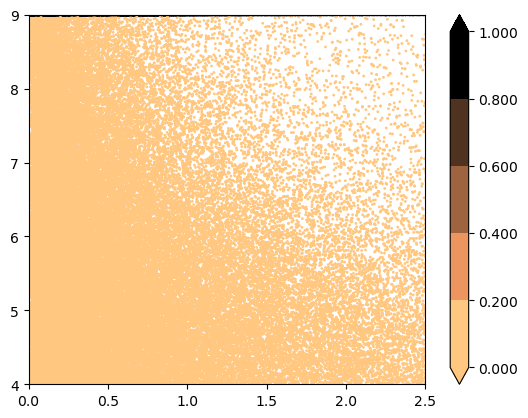

In [83]:
ax = plt.axes()
plt.scatter((plot['threeBRfillfac']),np.log10(plot['instability_time']), s=1, c=((plot['Stable'])), cmap=plt.cm.get_cmap("copper_r",5),alpha=1)
cbar = plt.colorbar(orientation="vertical", extend="both",
                   pad=0.05, shrink=1, aspect=20, format="%.3f")
ax.set_xlim([0,2.5])
ax.set_ylim([4,9])

In [ ]:
data = filtData[orbital+['instability_time']]

In [ ]:
data = data.drop(data[data['instability_time'] >=1e9].index)
#data = data.drop(data[data['instability_time'] <=1e4].index)

In [ ]:
data

,e1,e2,e3,a1,a2,a3,P1,P2,P3,pomega1,...,Omega1,Omega2,Omega3,w1,w2,w3,m1,m2,m3,instability_time
0,0.005031,0.059391,0.002515,1.0,1.221502,1.589043,0.999983,1.349987,2.003050,3.171041,...,1.770839,1.573978,-1.192440,1.400202,2.311349,1.084278,3.414016e-05,1.878725e-05,1.826900e-06,1.235665e+07
1,0.010350,0.013048,0.072450,1.0,1.190647,1.671403,1.000000,1.299174,2.160777,-3.564030,...,-1.493638,-1.749616,-0.619350,4.212794,4.548066,0.275475,2.529838e-07,3.485790e-05,1.955797e-05,1.348749e+05
2,0.051912,0.042326,0.003395,1.0,1.125660,1.936762,0.999963,1.194207,2.695151,0.995149,...,2.705977,-0.032550,2.795101,4.572357,4.575369,0.624064,7.380789e-05,6.974008e-05,1.477931e-07,1.276428e+04
4,0.001457,0.020334,0.010325,1.0,1.034058,1.059346,1.000000,1.051519,1.090326,1.738448,...,1.084883,-0.455684,-1.253823,0.653565,1.802802,0.038984,5.106746e-07,2.039380e-07,1.542321e-06,8.791890e+01
6,0.030108,0.010855,0.027982,1.0,1.223957,1.251277,0.999988,1.354060,1.399645,-1.244602,...,-1.697561,-1.997728,-1.224442,0.452959,5.379999,4.702908,2.398945e-05,2.923224e-05,2.851700e-06,1.493028e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,0.098697,0.055973,0.038755,1.0,1.664222,1.801058,1.000000,2.146925,2.417061,-1.392740,...,-1.986416,-1.304489,0.789342,0.593676,3.118004,1.581420,7.421231e-05,3.262045e-07,1.797223e-05,6.990387e+05
138539,0.042992,0.029663,0.000991,1.0,1.251338,1.592730,1.000000,1.399777,2.010059,0.345426,...,0.105004,-2.622912,2.787067,0.240422,1.816402,5.636983,7.304962e-07,1.252616e-05,7.962694e-06,3.075749e+08
138540,0.047731,0.084424,0.000777,1.0,1.131799,1.546790,1.000000,1.204069,1.923727,2.936098,...,0.721274,-0.121158,-1.067540,2.214824,3.206445,4.796260,9.256666e-05,1.185978e-05,3.800687e-06,1.193822e+07
138541,0.185046,0.091380,0.042639,1.0,1.209454,1.687277,1.000000,1.330065,2.191636,2.906814,...,2.339363,0.325401,-0.535495,0.567451,0.656802,1.096172,1.973852e-05,5.127421e-05,1.439586e-07,2.064407e+08


In [ ]:
data['logInstab'] = np.log10(data['instability_time'])

In [ ]:
data

,e1,e2,e3,a1,a2,a3,P1,P2,P3,pomega1,...,Omega2,Omega3,w1,w2,w3,m1,m2,m3,instability_time,logInstab
0,0.005031,0.059391,0.002515,1.0,1.221502,1.589043,0.999983,1.349987,2.003050,3.171041,...,1.573978,-1.192440,1.400202,2.311349,1.084278,3.414016e-05,1.878725e-05,1.826900e-06,1.235665e+07,7.091901
1,0.010350,0.013048,0.072450,1.0,1.190647,1.671403,1.000000,1.299174,2.160777,-3.564030,...,-1.749616,-0.619350,4.212794,4.548066,0.275475,2.529838e-07,3.485790e-05,1.955797e-05,1.348749e+05,5.129931
2,0.051912,0.042326,0.003395,1.0,1.125660,1.936762,0.999963,1.194207,2.695151,0.995149,...,-0.032550,2.795101,4.572357,4.575369,0.624064,7.380789e-05,6.974008e-05,1.477931e-07,1.276428e+04,4.105996
4,0.001457,0.020334,0.010325,1.0,1.034058,1.059346,1.000000,1.051519,1.090326,1.738448,...,-0.455684,-1.253823,0.653565,1.802802,0.038984,5.106746e-07,2.039380e-07,1.542321e-06,8.791890e+01,1.944082
6,0.030108,0.010855,0.027982,1.0,1.223957,1.251277,0.999988,1.354060,1.399645,-1.244602,...,-1.997728,-1.224442,0.452959,5.379999,4.702908,2.398945e-05,2.923224e-05,2.851700e-06,1.493028e+02,2.174068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,0.098697,0.055973,0.038755,1.0,1.664222,1.801058,1.000000,2.146925,2.417061,-1.392740,...,-1.304489,0.789342,0.593676,3.118004,1.581420,7.421231e-05,3.262045e-07,1.797223e-05,6.990387e+05,5.844501
138539,0.042992,0.029663,0.000991,1.0,1.251338,1.592730,1.000000,1.399777,2.010059,0.345426,...,-2.622912,2.787067,0.240422,1.816402,5.636983,7.304962e-07,1.252616e-05,7.962694e-06,3.075749e+08,8.487951
138540,0.047731,0.084424,0.000777,1.0,1.131799,1.546790,1.000000,1.204069,1.923727,2.936098,...,-0.121158,-1.067540,2.214824,3.206445,4.796260,9.256666e-05,1.185978e-05,3.800687e-06,1.193822e+07,7.076940
138541,0.185046,0.091380,0.042639,1.0,1.209454,1.687277,1.000000,1.330065,2.191636,2.906814,...,0.325401,-0.535495,0.567451,0.656802,1.096172,1.973852e-05,5.127421e-05,1.439586e-07,2.064407e+08,8.314795


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing 

In [ ]:
#t = data.drop('instability_time', axis=1).drop('logInstab',axis=1)
t = data[a + e + m]
y = data['logInstab'] 
# X = pd.DataFrame.join(t,(t**2).add_prefix(2))
# X = pd.DataFrame.join(X, (t**3).add_prefix(3) )
# X = pd.DataFrame.join(X, (t**4).add_prefix(4) )
X = t
for i in range(2,5):
    X = pd.DataFrame.join(X,(t**i).add_prefix(str(i)))


In [47]:
for j in range(t.shape[1]):
    for i in range(t.shape[1]):
        X= pd.DataFrame.join(X,(t.iloc[:,i]*t.iloc[:,j]),lsuffix=str(j)+str(i)+'_',rsuffix=str(j)+str(i))

ValueError: Other Series must have a name

In [41]:
t.iloc[:,2]*t.iloc[:,3]

0         0.007994
1         0.017299
2         0.100541
4         0.001544
6         0.037673
            ...   
138538    0.177759
138539    0.068475
138540    0.073829
138541    0.312223
138542    0.118200
Length: 103378, dtype: float64

In [28]:
X

,a1,a2,a3,e1,e2,e3,m1,m2,m3,2a1,...,3m3,4a1,4a2,4a3,4e1,4e2,4e3,4m1,4m2,4m3
0,1.0,1.221502,1.589043,0.005031,0.059391,0.002515,3.414016e-05,1.878725e-05,1.826900e-06,1.0,...,6.097394e-18,1.0,2.226263,6.375922,6.405933e-10,1.244169e-05,3.997747e-11,1.358508e-18,1.245813e-19,1.113933e-23
1,1.0,1.190647,1.671403,0.010350,0.013048,0.072450,2.529838e-07,3.485790e-05,1.955797e-05,1.0,...,7.481205e-15,1.0,2.009707,7.804139,1.147580e-08,2.898257e-08,2.755166e-05,4.096104e-27,1.476403e-18,1.463172e-19
2,1.0,1.125660,1.936762,0.051912,0.042326,0.003395,7.380789e-05,6.974008e-05,1.477931e-07,1.0,...,3.228214e-21,1.0,1.605568,14.070346,7.262301e-06,3.209461e-06,1.328387e-10,2.967640e-17,2.365538e-17,4.771077e-28
4,1.0,1.034058,1.059346,0.001457,0.020334,0.010325,5.106746e-07,2.039380e-07,1.542321e-06,1.0,...,3.668801e-18,1.0,1.143352,1.259366,4.510713e-12,1.709533e-07,1.136335e-08,6.801067e-26,1.729786e-27,5.658469e-24
6,1.0,1.223957,1.251277,0.030108,0.010855,0.027982,2.398945e-05,2.923224e-05,2.851700e-06,1.0,...,2.319058e-17,1.0,2.244218,2.451397,8.216731e-07,1.388261e-08,6.130923e-07,3.311929e-19,7.302112e-19,6.613259e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,1.0,1.664222,1.801058,0.098697,0.055973,0.038755,7.421231e-05,3.262045e-07,1.797223e-05,1.0,...,5.805046e-15,1.0,7.670876,10.522309,9.488844e-05,9.815710e-06,2.255779e-06,3.033219e-17,1.132296e-26,1.043296e-19
138539,1.0,1.251338,1.592730,0.042992,0.029663,0.000991,7.304962e-07,1.252616e-05,7.962694e-06,1.0,...,5.048707e-16,1.0,2.451873,6.435298,3.416268e-06,7.742044e-07,9.649035e-13,2.847553e-25,2.461910e-20,4.020131e-21
138540,1.0,1.131799,1.546790,0.047731,0.084424,0.000777,9.256666e-05,1.185978e-05,3.800687e-06,1.0,...,5.490175e-17,1.0,1.640883,5.724335,5.190300e-06,5.079995e-05,3.645828e-13,7.342068e-17,1.978362e-20,2.086644e-22
138541,1.0,1.209454,1.687277,0.185046,0.091380,0.042639,1.973852e-05,5.127421e-05,1.439586e-07,1.0,...,2.983408e-21,1.0,2.139722,8.104858,1.172510e-03,6.972710e-05,3.305436e-06,1.517952e-19,6.911877e-18,4.294872e-28


In [48]:
t.shape

(95900, 21)

In [33]:
t.iloc[:,2]*t.iloc[:,2]

0         2.525059
1         2.793589
2         3.751046
4         1.122215
6         1.565694
            ...   
138538    3.243811
138539    2.536789
138540    2.392558
138541    2.846903
138542    2.861433
Name: a3, Length: 103378, dtype: float64

In [29]:
# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=101) 
  
# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train) 
  
# making predictions 
predictions = model.predict(X_test) 
  
# model evaluation 
print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions)) 

mean_squared_error :  2.0288401718053186
mean_absolute_error :  1.100642490659273


(4.0, 9.0)

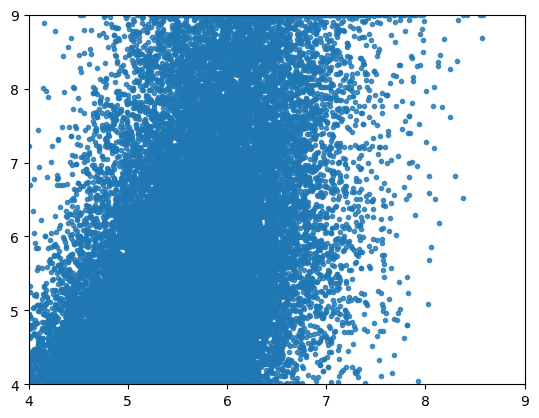

In [30]:
ax = plt.axes()
plt.scatter(model.predict(X_test),y_test, marker = '.', alpha = 0.8)
ax.set_xlim([4,9])
ax.set_ylim([4,9])